In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/voxel-raw/data_n100000_nf3_b1000b2000b3000_edge125_noiseless.mat


In [3]:
import matplotlib.pyplot as plt
import numpy as np          
from os.path import dirname, join as pjoin
import scipy.io as sio
import torch

from math import cos,sin

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

In [4]:
mat_fname = "/kaggle/input/voxel-raw/data_n100000_nf3_b1000b2000b3000_edge125_noiseless.mat"
mat_contents = sio.loadmat(mat_fname, spmatrix=False)

In [5]:
dwi_data = mat_contents['dwi']
voxt_directions = mat_contents['voxt']['directions']
voxt_ndir = mat_contents['voxt']['ndir']

In [6]:
dwi_df = pd.DataFrame(dwi_data)

In [7]:
dwi_df['voxt_directions'] = voxt_directions[0]
dwi_df['voxt_ndir'] = voxt_ndir[0]

In [8]:
trueX=[]
trueY=[]
trueZ=[]
for i in dwi_df['voxt_directions'] :
    el, az = i[0][0], i[0][1]
    trueX.append(cos(el)*cos(az))
    trueY.append(cos(el)*sin(az))
    trueZ.append(sin(el))
len(trueX), len(trueY), len(trueZ)

(100000, 100000, 100000)

In [9]:
dwi_df['trueX'] = trueX 
dwi_df['trueY'] = trueY
dwi_df['trueZ'] = trueZ 

In [10]:
#cleaning ndir
dwi_df['voxt_ndir'] = dwi_df['voxt_ndir'].apply(lambda x: x[0][0] if isinstance(x, np.ndarray) else x)
dwi_df.head()

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,voxt_directions,voxt_ndir,trueX,trueY,trueZ
0,1.0,0.384153,0.418521,0.455972,0.341455,0.436808,0.368936,0.459862,0.372158,0.351873,...,0.071571,0.167355,0.219863,0.319505,0.082791,"[[1.093523101619975, -1.0712505488597581], [1....",3,0.220045,-0.403225,0.888251
1,1.0,0.395778,0.384606,0.216946,0.307236,0.560694,0.544845,0.506081,0.409586,0.440736,...,0.361092,0.086021,0.179503,0.095435,0.060580,"[[-2.702678926300885, -0.8255197339091209]]",1,-0.613893,0.665242,-0.424956
2,1.0,0.486848,0.395559,0.440019,0.484773,0.377528,0.528064,0.334176,0.548768,0.566366,...,0.441554,0.105825,0.094855,0.051356,0.286201,"[[-1.284640164282406, 0.10745114508583531], [0...",2,0.280639,0.030272,-0.959336
3,1.0,0.412950,0.345664,0.169567,0.706696,0.529414,0.376036,0.715192,0.665584,0.432066,...,0.025808,0.106044,0.210483,0.140951,0.383397,"[[0.7855602789322647, -1.2172543959888724]]",1,0.244777,-0.663266,0.707221
4,1.0,0.381064,0.537113,0.364683,0.485454,0.263963,0.530239,0.319479,0.550543,0.450314,...,0.192081,0.117127,0.321770,0.152498,0.066113,"[[-1.7427986708082914, 0.6527871588092062], [-...",2,-0.135965,-0.103960,-0.985244


In [12]:
dwi_n1_df = dwi_df[dwi_df['voxt_ndir'] == 1].copy()

In [14]:
dwi_n1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,voxt_directions,voxt_ndir,trueX,trueY,trueZ
1,1.0,0.395778,0.384606,0.216946,0.307236,0.560694,0.544845,0.506081,0.409586,0.440736,...,0.361092,0.086021,0.179503,0.095435,0.060580,"[[-2.702678926300885, -0.8255197339091209]]",1,-0.613893,0.665242,-0.424956
3,1.0,0.412950,0.345664,0.169567,0.706696,0.529414,0.376036,0.715192,0.665584,0.432066,...,0.025808,0.106044,0.210483,0.140951,0.383397,"[[0.7855602789322647, -1.2172543959888724]]",1,0.244777,-0.663266,0.707221
11,1.0,0.511049,0.359586,0.493149,0.187019,0.192782,0.308395,0.187532,0.224024,0.426708,...,0.148123,0.338358,0.021886,0.148186,0.004427,"[[-1.0082398951799352, 0.2501501841759648]]",1,0.516750,0.132031,-0.845894
12,1.0,0.547446,0.100360,0.224700,0.447906,0.501215,0.106604,0.206014,0.297847,0.361080,...,0.003096,0.558039,0.001672,0.649440,0.183664,"[[-0.9085123257929317, -0.7666894481507877]]",1,0.442872,-0.426603,-0.788590
15,1.0,0.298475,0.322285,0.356936,0.564265,0.757450,0.266399,0.693068,0.384987,0.257640,...,0.009024,0.065984,0.077374,0.166415,0.464934,"[[0.004608795927990794, -0.7862899064389937]]",1,0.706468,-0.707730,0.004609


In [15]:
b_table = mat_contents['b_table'] 
b_values = b_table[0, :]

# Get b-vectors (rows 1, 2, 3)
b_vectors = b_table[1:4, :].T # Transpose to get shape (num_directions, 3)

data = {
    'b_value': b_values,
    'b_vector_x': b_vectors[:, 0],
    'b_vector_y': b_vectors[:, 1],
    'b_vector_z': b_vectors[:, 2]
}

b_table_df = pd.DataFrame(data)

In [16]:
b_table_df.head()

,b_value,b_vector_x,b_vector_y,b_vector_z
0,0.000000,0.000000,0.000000,0.000000
1,1006.027789,-0.891291,-0.365323,0.268587
2,1006.027789,-0.378301,0.560127,0.736985
3,1006.027789,-0.048479,0.060345,0.997000
4,1006.027789,0.886465,-0.411969,0.210859


In [17]:
print(dwi_n1_df.shape, b_table_df.shape)

(33396, 276) (271, 4)


In [18]:
# Step 1: Extract DWI values from columns 1 to 270 (exclude b=0, which is column 0)
dwi_data = dwi_n1_df.loc[:, 1:270].astype(np.float32).values  # shape: [33396, 270]

# Step 2: Filter out b=0 row in b_table
b_table_filtered = b_table_df.iloc[1:].reset_index(drop=True)  # shape: [270, 4]

# Step 3: Get bvals and bvecs
bvals = b_table_filtered["b_value"].values.astype(np.float32)          # shape: [270]
bvecs = b_table_filtered[["b_vector_x", "b_vector_y", "b_vector_z"]].values.astype(np.float32)  # [270, 3]

# Step 4: Build per-voxel sequence of 270 vectors (each [dwi, bval, bx, by, bz])
def build_voxel_input(dwi_voxel):
    # shape: [270, 1] for signal, [270, 1] for bval, [270, 3] for bvecs
    return np.concatenate([
        dwi_voxel[:, None],          # [270, 1]
        bvals[:, None],              # [270, 1]
        bvecs                        # [270, 3]
    ], axis=1)  # → [270, 5]

# Step 5: Apply to all voxels
X = np.stack([build_voxel_input(row) for row in dwi_data])  # shape: [33396, 270, 5]

# Step 6: Extract target output
Y = dwi_n1_df[["trueX", "trueY", "trueZ"]].values.astype(np.float32)  # shape: [33396, 3]

print("Transformer input shape (X):", X.shape)  # (33396, 270, 5)
print("Target output shape (Y):", Y.shape)      # (33396, 3)

Transformer input shape (X): (33396, 270, 5)
Target output shape (Y): (33396, 3)


In [19]:
# X: [N, 270, 5]  
# Y: [N, 3]       # true directions (unit vectors)
# bvecs: [270, 3] # direction vectors only (already unit normed)

# Step 1: normalize bvecs and true directions (just in case)
bvecs_unit = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)
Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)

# Step 2: compute dot product for all voxels
dot_products = np.matmul(Y_unit, bvecs_unit.T)  # [N, 270]

# Step 3: take the argmax across directions
labels = np.argmax(dot_products, axis=1).astype(np.int64)  # [N]

In [20]:
from torch.utils.data import DataLoader, Dataset

class DwiClassificationDataset(Dataset):
    def __init__(self, X, labels):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx]

# Initialize dataset and loader
dataset = DwiClassificationDataset(X, labels)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [21]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=5, nhead=4, num_layers=2, num_classes=270):
        super().__init__()
        self.embed = nn.Linear(input_dim, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),           # [B, 64, 1]
            nn.Flatten(),                      # [B, 64]
            nn.Linear(64, num_classes)         # [B, 270]
        )

    def forward(self, x):
        # x: [B, 270, 5]
        x = self.embed(x)              # [B, 270, 64]
        x = x.permute(1, 0, 2)         # [270, B, 64] for transformer
        x = self.transformer(x)        # [270, B, 64]
        x = x.permute(1, 2, 0)         # [B, 64, 270]
        logits = self.cls_head(x)     # [B, 270]
        return logits

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
model = TransformerClassifier()
model = TransformerClassifier().to(device)
#model.load_state_dict(torch.load("classifier_model.pth", map_location=device))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
best_loss = float('inf')
for epoch in range(num_epochs):
    #print(f"epoch: {epoch}")
    total_loss = 0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        total_loss += loss.item() * X_batch.size(0)
        
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "classifier_model.pth")
        print("Saved best model.")

Epoch 0: Train Loss = 4.2548
Saved best model.
Epoch 1: Train Loss = 4.1957
Saved best model.
Epoch 2: Train Loss = 4.1912
Saved best model.
Epoch 3: Train Loss = 4.1885
Saved best model.
Epoch 4: Train Loss = 4.1869
Saved best model.
Epoch 5: Train Loss = 4.1862
Saved best model.
Epoch 6: Train Loss = 4.1846
Saved best model.
Epoch 7: Train Loss = 4.1837
Saved best model.
Epoch 8: Train Loss = 4.1830
Saved best model.
Epoch 9: Train Loss = 4.1816
Saved best model.
Epoch 10: Train Loss = 4.1821
Epoch 11: Train Loss = 4.1809
Saved best model.
Epoch 12: Train Loss = 4.1798
Saved best model.
Epoch 13: Train Loss = 4.1804
Epoch 14: Train Loss = 4.1790
Saved best model.
Epoch 15: Train Loss = 4.1793
Epoch 16: Train Loss = 4.1791
Epoch 17: Train Loss = 4.1781
Saved best model.
Epoch 18: Train Loss = 4.1784
Epoch 19: Train Loss = 4.1776
Saved best model.
Epoch 20: Train Loss = 4.1778
Epoch 21: Train Loss = 4.1779
Epoch 22: Train Loss = 4.1776
Saved best model.
Epoch 23: Train Loss = 4.1776
Ep

In [24]:
model = TransformerClassifier().to(device)
model.load_state_dict(torch.load("classifier_model.pth", map_location=device))
model.eval()

TransformerClassifier(
  (embed): Linear(in_features=5, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cls_head): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=64, out_features=270, bias=True)
  )
)

In [26]:
loader = DataLoader(DwiClassificationDataset(X, labels), batch_size=256)
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)  # [B, 270]
        probs = torch.softmax(logits, dim=1)  # [B, 270]
        pred_idx = torch.argmax(probs, dim=1).cpu().numpy()

        all_preds.append(pred_idx)
        all_labels.append(yb.numpy())
        all_probs.append(probs.cpu().numpy())

pred_indices = np.concatenate(all_preds)         # [N]
true_indices = np.concatenate(all_labels)        # [N]
prob_distributions = np.concatenate(all_probs)   # [N, 270]
np.save("output_probabilities.npy", prob_distributions)
# pred_dirs = bvecs[pred_indices]                  # [N, 3]
# Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)
# pred_unit = pred_dirs / np.linalg.norm(pred_dirs, axis=1, keepdims=True)

# dot = np.clip(np.sum(Y_unit * pred_unit, axis=1), -1.0, 1.0)
# angles = np.degrees(np.arccos(dot))

# print(f"Mean Angular Error: {angles.mean():.2f}°")
# print(f"Median Angular Error: {np.median(angles):.2f}°")
# print(f"90th Percentile Angular Error: {np.percentile(angles, 90):.2f}°")

# # Save softmax probabilities


# # Histogram of angular errors
# plt.figure(figsize=(8, 5))
# plt.hist(angles, bins=50, color='skyblue', edgecolor='black')
# plt.title("Angular Error Distribution")
# plt.xlabel("Angular Error (degrees)")
# plt.ylabel("Count")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("angular_error_histogram.png")
plt.close()

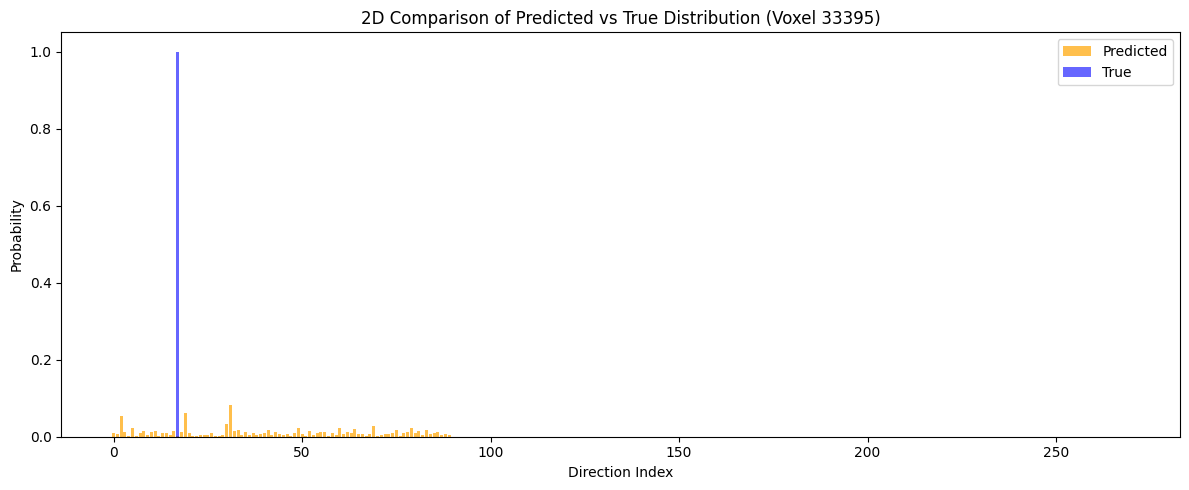

Error  Angle in radians: 1.1407987200166843
Error Angle in degrees: 65.36295193088247


In [37]:
##### import numpy as np
import matplotlib.pyplot as plt

# Load data
probs = np.load("output_probabilities.npy")      # shape: [N, 270]
#print(len())
# Choose voxel
voxel_idx = 33395
voxel_probs = probs[voxel_idx]  # [270]
true_label = labels[voxel_idx]  # scalar

# Reference one-hot distribution
ref_probs = np.zeros_like(voxel_probs)
ref_probs[true_label] = 1.0

# Plot 2D bar chart of predicted vs reference probabilities
plt.figure(figsize=(12, 5))
x = np.arange(len(voxel_probs))

plt.bar(x, voxel_probs, label="Predicted", alpha=0.7, color='orange')
plt.bar(x, ref_probs, label="True", alpha=0.6, color='blue')

plt.xlabel("Direction Index")
plt.ylabel("Probability")
plt.title(f"2D Comparison of Predicted vs True Distribution (Voxel {voxel_idx})")
plt.legend()
plt.tight_layout()
plt.savefig(f"voxel_{voxel_idx}_2d_prob_comparison.png")
plt.show()



voxel0_cuda = probs[voxel_idx]
voxel0_cpu = voxel0_cuda
voxel0_cpu_numpy = voxel0_cpu
#print(len(voxel0_cpu_numpy))
voxel0_maxdir = np.argmax(voxel0_cpu_numpy)
voxel0_maxdir

angle_rad=calculate_angular_error(X[voxel_idx][voxel0_maxdir][2:], Y[voxel_idx])
angle_deg = np.degrees(angle_rad)

print(f"Error  Angle in radians: {angle_rad}")
print(f"Error Angle in degrees: {angle_deg}")

In [35]:
len(probs)

33396

In [30]:
def calculate_angular_error(vector_a, vector_b):

    dot_product = np.dot(vector_a, vector_b)
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)

    if magnitude_a == 0 or magnitude_b == 0:
        return 0.0  

    cosine_angle = dot_product / (magnitude_a * magnitude_b)

    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)

    angle_radians = np.arccos(cosine_angle)
    return angle_radians

vector1 = np.array([-2.2037783e-01,-1.1440272e-01,-9.6868241e-01])
vector2 = np.array([-0.61389345,  0.66524196, -0.4249564 ])
vector3 = -vector1
print(vector3)

angle_rad = calculate_angular_error(vector1, vector2)
angle_deg = np.degrees(angle_rad)

print(f"Angle in radians: {angle_rad}")
print(f"Angle in degrees: {angle_deg}")

[0.22037783 0.11440272 0.96868241]
Angle in radians: 1.0805640549967162
Angle in degrees: 61.91175984485401


In [31]:
angular_errors_deg = []

for i in range(len(X)):
    # Get predicted direction index for this voxel
    pred_idx = np.argmax(prob_distributions[i])  # [270]

    # Extract predicted b-vector from input X
    pred_vec = X[i][pred_idx][2:]  # [bx, by, bz]

    # Get ground truth vector
    true_vec = Y[i]  # [x, y, z]

    # Compute angular error
    angle_rad = calculate_angular_error(pred_vec, true_vec)
    angle_deg = np.degrees(angle_rad)

    angular_errors_deg.append(angle_deg)

In [32]:
angles = np.array(angular_errors_deg)
print(f"Mean Angular Error: {angles.mean():.2f}°")
print(f"Median Angular Error: {np.median(angles):.2f}°")
print(f"90th Percentile Angular Error: {np.percentile(angles, 90):.2f}°")

Mean Angular Error: 90.05°
Median Angular Error: 90.37°
90th Percentile Angular Error: 159.84°


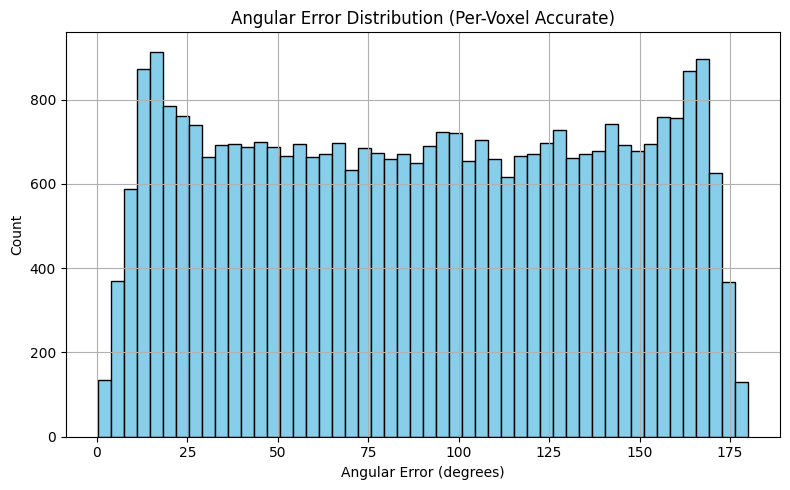

In [33]:
plt.figure(figsize=(8, 5))
plt.hist(angles, bins=50, color='skyblue', edgecolor='black')
plt.title("Angular Error Distribution (Per-Voxel Accurate)")
plt.xlabel("Angular Error (degrees)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("angular_error_histogram_correct.png")
plt.show()